In [1]:
%matplotlib inline

# Regression Analysis

Regression is a type of statistical modeling that allows to investigate whether a variable is dependent on others. The relationship between variables is illustrated by a trend-line which is overlaid on the data and can be used for predicting many different things.

<img src="res/linear-regression-4.png" width="400">


## Prerequisites

In [2]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

set_default()

### Running on a GPU: device string
Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

To ensure the reproducibility, we need to limit the nondeterministic behavior of the platform. We can choose spesific seed to control the randomness (have determinism) over multiple executions.

In [4]:
seed = 1
random.seed(seed)
torch.manual_seed(seed);

## Create the data
Let's prepare a <b>one-dimensional float tensor</b> ``X`` of size ``N`` with values evenly spaced from -1 to 1 using ``torch.linspace`` as our training data.

In [5]:
N = 100  # number of samples
X = torch.unsqueeze(torch.linspace(-1, 1, N), dim=1).to(device) # training data

The ground-truth label ``y`` is generated using formula 
\begin{equation} y = X^3 + 0.3 * rn \end{equation} 
with $rn$ is a random number from a uniform distribution on the interval \[0,1\) that can be generated using ``torch.rand``. ``y`` is also a <b> one-dimensional float tensor </b>.

In [6]:
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

In [7]:
print("Shapes of the data:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes of the data:
X: (100, 1)
y: (100, 1)


Let's plot the data

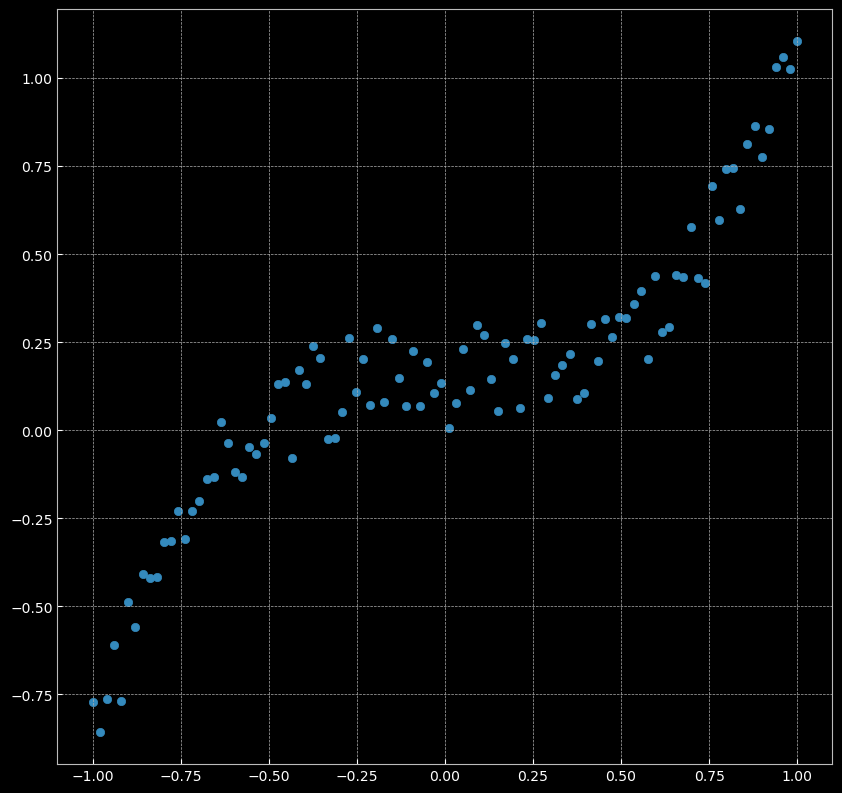

In [8]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

From the plot above we can roughly see the relationship between x and y. Now we can try drawing a line that can generally describe the relationship between those two.

## Linear Regression

Linear regression models the relationship between the variables using a linear equation, 
\begin{equation} Y = a + b X_1 + c X_2 + ... \end{equation} 

Let's build a linear model that fit the data.

### Define the network

Now we will make a linear model with one hidden layer using ``nn.linear``. 
* The input is 1 dimension for training data ``X``. ``X`` is a <b> one-dimensional float tensor </b>.
* We use 100 hidden units
* The output dimension is also 1 since we want to predict label ``y_pred`` which is also a <b> one-dimensional float tensor </b>.

In [9]:
D = 1  # input dimensions
C = 1  # output dimensions
H = 100  # num_hidden_units

In [10]:
learning_rate = 1e-3
lambda_l2 = 1e-5

model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA if exists

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)

The most important arguments to compile are the loss and the optimizer since these define what will be optimized. We can calculate the error for the predicted label ``y_pred`` using using MSE loss for the regression task. As for optimizer, Adam is applied using ``torch.optim`` package.

In [11]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

### Training 

Train the model for 1000 epoch with training data ``X`` and ground truth label ``y`` we created in the beginning. The loss is calculated between ground truth label ``y`` and predicted label ``y_pred``.

In [12]:
epochs = 1000

for t in range(epochs):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t+1, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 1000, [LOSS or MSE]: 0.029701


### Plot
Let's see how the nonlinear model fitting the data by plotting the predicted label ``y_pred`` against the training data ``X``.

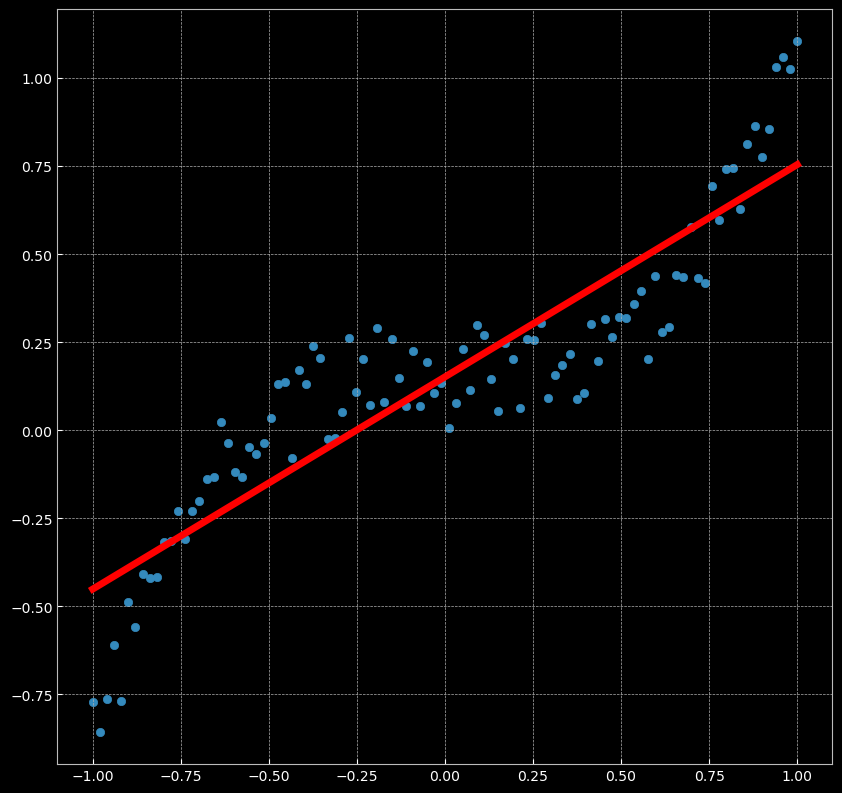

In [13]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())  # training data X - ground truth label y
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5) # training data X - predicted label y_pred
plt.axis('equal');

## Nonlinear regression

We see that the trained model could not fit the data well. Thus we want to introduce non-linearities to approximate the function. Nonlinear regression can provide flexible curve-fitting functionality. There are several non-linearities that can be used. The most popular ones used for nonlinear regression in neural network architecture is ReLU, TanH, and Sigmoid. 

<img src="res/activation-functions.jpg" width="400">


### Define the network

We will make a nonlinear model with one hidden layer using ``nn.linear``. This time we will add Rectified Linear Unit into the network using ``nn.ReLU``
* The input is 1 dimension for training data ``X``. ``X`` is a <b> one-dimensional float tensor </b>.
* We use 100 hidden units
* The output dimension is also 1 since we want to predict label ``y_pred`` which is also a <b> one-dimensional float tensor </b>.
* Apply ``nn.ReLu``

In [14]:
D = 1  # input dimensions
C = 1  # output dimensions
H = 100  # num_hidden_units

In [15]:
learning_rate = 1e-3
lambda_l2 = 1e-5

model_nl = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(), # non-linearity
    nn.Linear(H, C)
)

model_nl.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_nl.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

### Training 

Train the model for 1000 epoch with training data ``X`` and ground truth label ``y`` we created in the beginning. The loss is calculated between ground truth label ``y`` and predicted label ``y_pred``

In [17]:
epochs = 1000

for t in range(epochs):
    
    # Feed forward to get the logits
    y_pred = model_nl(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t+1, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 1000, [LOSS or MSE]: 0.006264


### Plot
Let's see how the trained model fitting the data by plotting the predicted label ``y_pred`` against the training data ``X``.

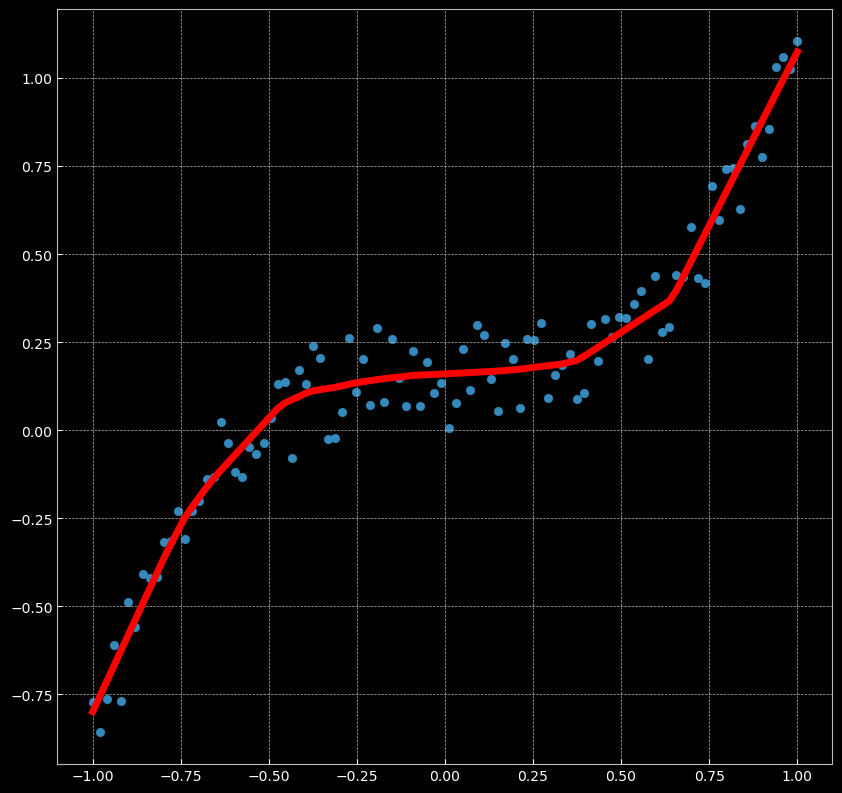

In [18]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy()) # training data X - ground truth label y
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5) # training data X - predicted label y_pred
plt.axis('equal');

We see that the nonlinear model fits the data better compared to the linear model.

# Hands-on Exercises

## Exercise 1

In this section we will try using another non-linearity: hyperbolic tanget (tanh) function.
* Define a new neural network with tanh nonlinearity using ``nn.Tanh()``
* Train the model with data ``X`` and ``y`` we created in the beginning for 1000 epochs
* Will it be different compared to when using ReLu as the nonlinearity?

### Define the network

We will make a nonlinear model with one hidden layer using ``nn.linear``. We will add hyperbolic tangent function into the network using ``nn.Tanh``
* The input is 1 dimension for training data ``X``. ``X`` is a <b> one-dimensional float tensor </b>.
* We use 100 hidden units
* The output dimension is also 1 since we want to predict label ``y_pred`` which is also a <b> one-dimensional float tensor </b>.
* Apply ``nn.Tanh``

In [19]:
D = 1  # input dimensions
C = 1  # output dimensions
H = 100  # num_hidden_units

In [20]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)

learning_rate = 1e-3
lambda_l2 = 1e-5

# define a network with tanh nonlinearity
model_nl2 = nn.Sequential(
    nn.Linear(D, H),
    nn.Tanh(), # non-linearity
    nn.Linear(H, C)
)

model_nl2.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

Define loss and optimizer

In [21]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_nl2.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

### Training
Train for 1000 epochs with training data ``X`` and ground truth label ``y`` we created in the beginning. The loss is calculated between ground truth label ``y`` and predicted label ``y_pred``

In [22]:
epochs = 1000

for t in range(epochs):
    
    # Feed forward to get the logits
    y_pred = model_nl2(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t+1, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 1000, [LOSS or MSE]: 0.007750


In [23]:
print(model_nl2)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


### Plot
Let's see how the trained model with tanh nonlinearity fits the data

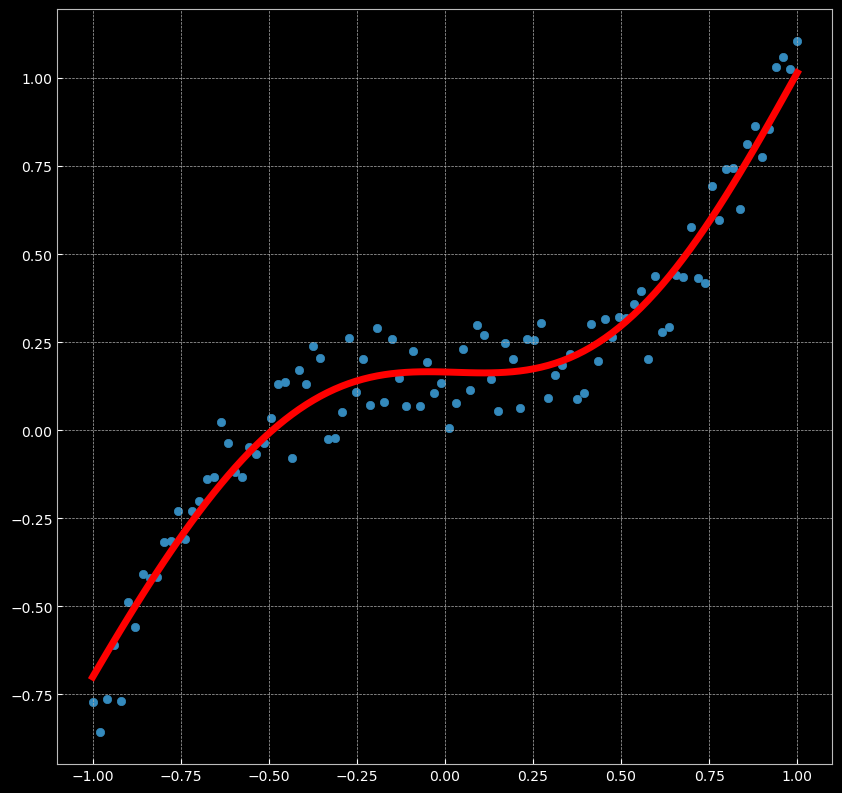

In [24]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');

## Exercise 2

In this section we will create a new dataset and train a nonlinear model to fit it.
* Create a new training data ``X_2`` with only 10 samples with values evenly spaced from 0 to 1 using ``torch.linspace``
* Create a new ground-truth label ``y_2`` using formula 
    \begin{equation} y = X^3 - 0.25 * rn \end{equation} 
  with $rn$ is a random number from a uniform distribution on the interval \[0,1\) that can be generated using ``torch.rand``.
* Train a nonlinear model with ReLu to fit the new dataset
* Does it fit well? What if the nonlinearity is changed to tanh?

In [25]:
seed = 42
random.seed(seed)
torch.manual_seed(seed);

In [26]:
# Define the number of samples here
_N = 10

# Create training data X_2
X_2 = torch.unsqueeze(torch.linspace(0, 1, _N), dim=1).to(device)

# Create a ground truth label y_2
y_2 = X_2.pow(3) - 0.25 * torch.rand(X_2.size()).to(device)

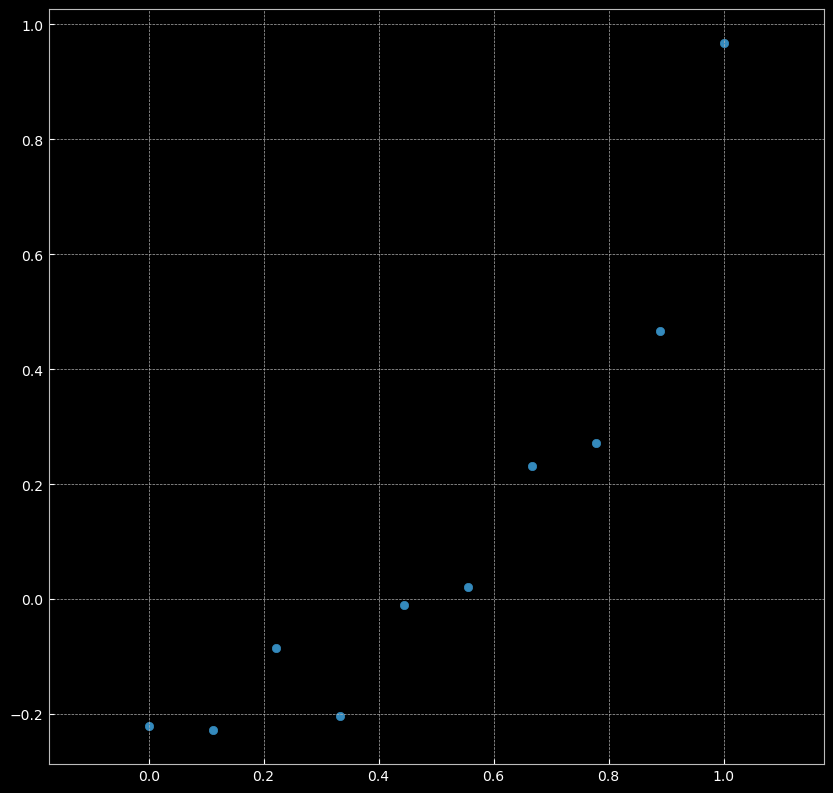

In [27]:
# See how the new dataset looks like
plt.scatter(X_2.cpu().numpy(), y_2.cpu().numpy())
plt.axis('equal');

### Define the network

We will make a nonlinear model with one hidden layer using ``nn.linear``. This time we will add Rectified Linear Unit into the network using ``nn.ReLU``
* The input is 1 dimension for the newly created training data ``X_2``. ``X_2`` is a <b> one-dimensional float tensor </b>.
* We use 100 hidden units
* The output dimension is also 1 since we want to predict label ``y_2pred`` which is also a <b> one-dimensional float tensor </b>.
* Apply ``nn.ReLu``

In [28]:
D = 1  # input dimensions
C = 1  # output dimensions
H = 100  # num_hidden_units

In [29]:
learning_rate = 1e-3
lambda_l2 = 1e-5

model_nl = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(), # non-linearity
    nn.Linear(H, C)
)

model_nl.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [30]:
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model_nl.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

### Training 

Train the model for 1000 epoch for the newly created training data ``X_2`` and ground truth label ``y_2``. The loss is calculated between ground truth label ``y_2`` and predicted label ``y_2pred``

In [31]:
epochs = 1000

for t in range(epochs):
    
    # Feed forward to get the logits
    y_2pred = model_nl(X_2)
    
    # Compute the loss (MSE)
    loss = criterion(y_2pred, y_2)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t+1, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 1000, [LOSS or MSE]: 0.003801


In [32]:
print(model_nl)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)


### Plot
Let's see how the trained model with ReLu nonlinearity fits the new dataset

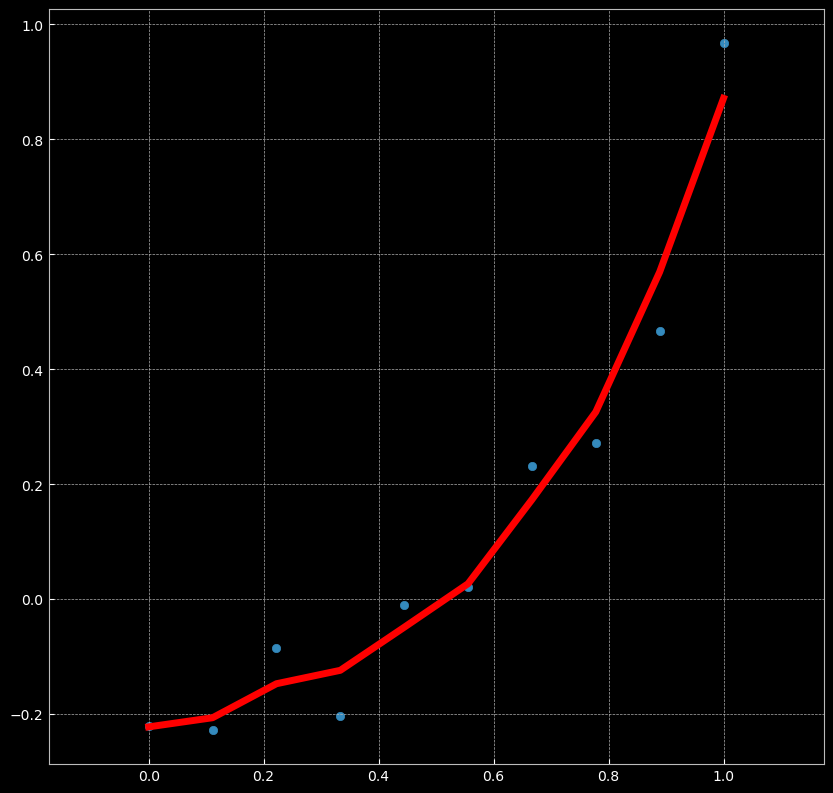

In [33]:
plt.scatter(X_2.data.cpu().numpy(), y_2.data.cpu().numpy()) # training data X_2 - ground truth label y_2
plt.plot(X_2.data.cpu().numpy(), y_2pred.data.cpu().numpy(), 'r-', lw=5) # training data X_2 - predicted label y_2pred
plt.axis('equal');

### Next tutorial: Training a classifier